# Customer Segmentation - Approach and Output

# Approach:
 1. Feature Engineering:
 - Extract RFM metrics (Recency, Frequency, Monetary) and customer region.
 - Use one-hot encoding for the 'Region' column to include categorical data.

 2. Data Scaling:
 - StandardScaler standardizes features for equal contribution in clustering.

 3. Elbow Method:
 - Determines the optimal number of clusters (k=4) by identifying the "elbow point" on the inertia plot.

 4. K-means Clustering:
 - K-means groups customers into 4 distinct clusters based on behavior and regional data.
 - Davies-Bouldin Index: 0.4381 (lower is better, indicating well-separated clusters).
 - Silhouette Score: 0.7124 (higher is better, indicating compact and distinct clusters).

 5. PCA Visualization:
 - PCA reduces the feature space to 2 dimensions for easier visualization.
 - The scatter plot shows clear cluster separation with distinct groups.

 Output:
 - Clustering results are saved to 'Customer_Segments.csv' for further analysis.
 - Clusters reveal behavioral patterns for segmentation and targeted marketing.

# Business Insights:
 1. High-value clusters can be targeted with personalized campaigns.
 2. Low-value clusters can be re-engaged with promotions to boost retention.
 3. Periodic re-clustering can capture shifts in customer behavior over time.


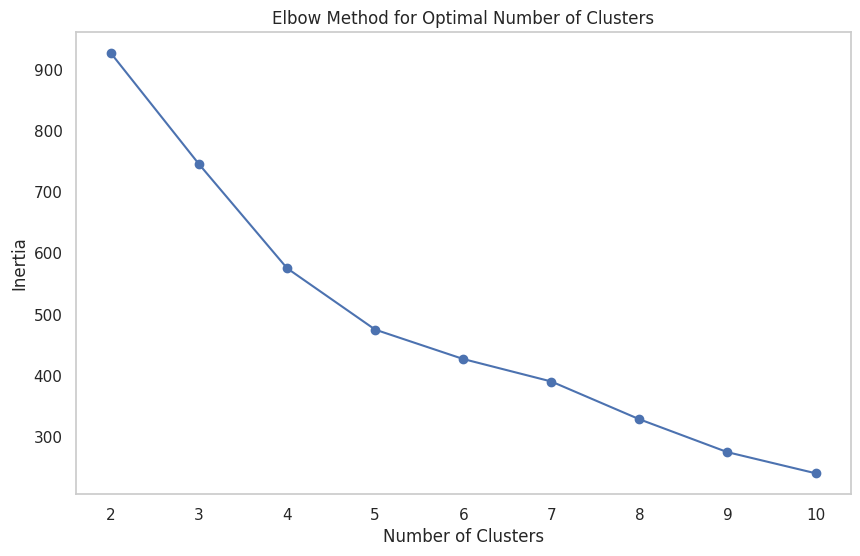

Davies-Bouldin Index (DB Index): 1.1447
Silhouette Score: 0.3391


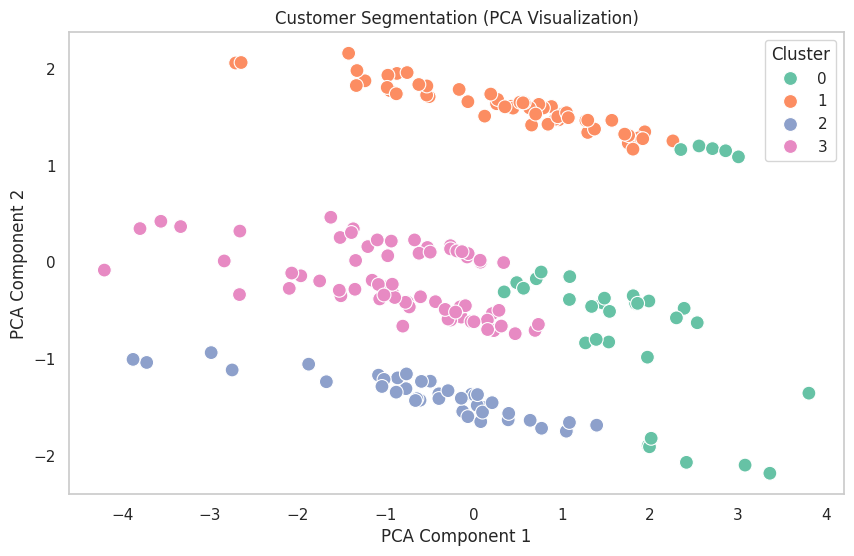

Clustering results saved to Customer_Segments.csv.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Cleaned_Customers.csv')
transactions = pd.read_csv('Cleaned_Transactions.csv')

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
latest_date = transactions['TransactionDate'].max()

total_spending = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'Monetary'}, inplace=True)

frequency = transactions.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

recency = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (latest_date - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

features = total_spending.merge(frequency, on='CustomerID')
features = features.merge(recency, on='CustomerID')

features = features.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

features = pd.get_dummies(features, columns=['Region'], drop_first=True)

X = features.drop(columns=['CustomerID'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features['Cluster'] = clusters

db_index = davies_bouldin_score(X_scaled, clusters)
silhouette_avg = silhouette_score(X_scaled, clusters)

print(f'Davies-Bouldin Index (DB Index): {db_index:.4f}')
print(f'Silhouette Score: {silhouette_avg:.4f}')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=features['Cluster'], palette='Set2', s=100)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

features.to_csv('Customer_Segments.csv', index=False)
print("Clustering results saved to Customer_Segments.csv.")
